In [212]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [213]:
data='https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv'

In [214]:
!rm data.csv*
!wget $data

--2023-10-03 14:57:34--  https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1475504 (1.4M) [text/plain]
Saving to: ‘data.csv’

data.csv            100%[===================>]   1.41M  --.-KB/s    in 0.01s   

2023-10-03 14:57:34 (98.1 MB/s) - ‘data.csv’ saved [1475504/1475504]



In [215]:
df=pd.read_csv('data.csv')
df.head(2)


,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
0,BMW,1 Series M,2011,premium unleaded (required),335.0,6.0,MANUAL,rear wheel drive,2.0,"Factory Tuner,Luxury,High-Performance",Compact,Coupe,26,19,3916,46135
1,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Convertible,28,19,3916,40650


## Data Preparation

In [216]:
df_modified=df.copy()
df_modified.columns=df_modified.columns.str.lower().str.replace(' ','_')
df_modified=df_modified[['make', 'model', 'year', 'engine_hp',
       'engine_cylinders', 'transmission_type',  'vehicle_style',
       'highway_mpg', 'city_mpg','msrp']]
df_modified.rename(columns = {'msrp':'price'}, inplace = True)
df_modified=df_modified.fillna(0)



## Question 1

In [217]:
(df_modified['transmission_type'].mode())

0    AUTOMATIC
dtype: object

## Question 2

In [263]:
df_corr=df_modified[['engine_hp','engine_cylinders','highway_mpg','city_mpg']].corr()
corr_series=df_corr.unstack().sort_values()
corr_series.loc[lambda x : x != 1].sort_values(ascending=False)


highway_mpg       city_mpg            0.886829
city_mpg          highway_mpg         0.886829
engine_hp         engine_cylinders    0.774851
engine_cylinders  engine_hp           0.774851
engine_hp         highway_mpg        -0.415707
highway_mpg       engine_hp          -0.415707
engine_hp         city_mpg           -0.424918
city_mpg          engine_hp          -0.424918
engine_cylinders  city_mpg           -0.587306
city_mpg          engine_cylinders   -0.587306
engine_cylinders  highway_mpg        -0.614541
highway_mpg       engine_cylinders   -0.614541
dtype: float64

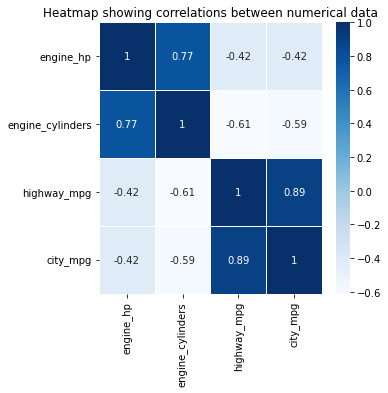

In [219]:
plt.figure(figsize=(5,5))  
sns.heatmap(df_modified[['engine_hp','engine_cylinders','highway_mpg','city_mpg']].corr(),annot=True,linewidths=.5, cmap="Blues")
plt.title('Heatmap showing correlations between numerical data')
plt.show()

## Calc Mean and add Avg.Price

In [220]:
msrp_mean=df_modified['price'].agg('mean')
msrp_mean

40594.737032063116

In [221]:
df_modified['above_avg']=df_modified['price'].apply(lambda x: 1 if x> msrp_mean else 0)
#del df_modified['above_avg']


## Split The data 60%/20%/20%

In [222]:
from sklearn.model_selection import train_test_split

In [223]:
df_train_full,df_test=train_test_split(df_modified, test_size=0.2,random_state=42)
df_train,df_val=train_test_split(df_train_full, test_size=0.25,random_state=42)

In [224]:
len(df_train),len(df_val),len(df_test)

(7148, 2383, 2383)

In [225]:
df_train.dtypes

make                  object
model                 object
year                   int64
engine_hp            float64
engine_cylinders     float64
transmission_type     object
vehicle_style         object
highway_mpg            int64
city_mpg               int64
price                  int64
above_avg              int64
dtype: object

## Question 3

In [226]:
from sklearn.metrics import mutual_info_score

In [227]:
def mutual_info_churn_score(series):
    return mutual_info_score(series,df_train.above_avg)

In [228]:
categorical_cols=list((df_train_full.dtypes[df_train_full.dtypes=='object']).index)
categorical_cols
numerical_cols=['year', 'engine_hp','engine_cylinders','highway_mpg', 'city_mpg']



In [229]:
mi=df_train[categorical_cols].apply(mutual_info_churn_score)
(round(mi.sort_values(),2).index[0],round(mi.sort_values(),2)[0])

('transmission_type', 0.02)

## Question 4

In [230]:
from sklearn.feature_extraction import DictVectorizer
from  sklearn.linear_model  import LogisticRegression


In [231]:
y_train=df_train.above_avg.values
y_test=df_test.above_avg.values
y_val=df_val.above_avg.values
y_train

df_val=df_val.drop(['price','above_avg'],axis=1)
df_train=df_train.drop(['price','above_avg'],axis=1)
df_test=df_test.drop(['price','above_avg'],axis=1)


### One Hot encoding using DictVectorizer

In [232]:
# train_dicts=df_train[categorical_cols+numerical_cols].to_dict(orient='records')
# val_dicts=df_val[categorical_cols+numerical_cols].to_dict(orient='records')
# test_dicts=df_test[categorical_cols+numerical_cols].to_dict(orient='records')

In [233]:
train_dicts=df_train.to_dict(orient='records')
val_dicts=df_val.to_dict(orient='records')
test_dicts=df_test.to_dict(orient='records')

In [234]:
dv=DictVectorizer(sparse=False)
dv.fit(train_dicts)
dv.fit(val_dicts)
dv.fit(test_dicts)


DictVectorizer(sparse=False)

In [235]:
X_train=dv.transform(train_dicts)
X_val=dv.transform(val_dicts)
X_test=dv.transform(test_dicts)

In [236]:
model = LogisticRegression(solver='liblinear', C=10, max_iter=1000, random_state=42)
model.fit(X_train,y_train)

LogisticRegression(C=10, max_iter=1000, random_state=42, solver='liblinear')

In [237]:
y_pred_val=model.predict_proba(X_val)
y_pred_val

array([[9.98916447e-01, 1.08355274e-03],
       [4.89565109e-03, 9.95104349e-01],
       [9.99786121e-01, 2.13879452e-04],
       ...,
       [9.99568290e-01, 4.31710400e-04],
       [6.33715667e-03, 9.93662843e-01],
       [1.28918062e-02, 9.87108194e-01]])

In [264]:
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings("ignore")

y_pred_val = model.predict_proba(X_val)[:, 1]
original_score = accuracy_score(y_val, y_pred_val >= 0.5)
original_score=round(original_score,2)
print(f"Accuracy for Q4 {original_score}")

Accuracy for Q4 0.94


In [240]:
q5_features=numerical_cols+categorical_cols
q5_features

['year',
 'engine_hp',
 'engine_cylinders',
 'highway_mpg',
 'city_mpg',
 'make',
 'model',
 'transmission_type',
 'vehicle_style']

## Question 5

In [272]:
#  df_q5=pd.DataFrame(columns=['feature','original_score','calc_score','score'])
def Q5():  
    data = []
   

    for feature  in q5_features:  
        features=q5_features.copy() 
        features.remove(feature)   
        train_dicts=df_train[features].to_dict(orient='records')
        val_dicts=df_val[features].to_dict(orient='records')       
        dv=DictVectorizer(sparse=False)
        dv.fit(train_dicts)
        dv.fit(val_dicts)
        

        X_train=dv.transform(train_dicts)
        X_val=dv.transform(val_dicts)
       
        model = LogisticRegression(solver='liblinear', C=10, max_iter=1000, random_state=42)
        model.fit(X_train,y_train)   

        
        y_pred_val = model.predict_proba(X_val)[:, 1]        
        score=accuracy_score(y_val, y_pred_val >= 0.5) 
        data.append({'feature': feature, 'original_score': original_score,
                      'score_diff':round(original_score - score,2),'score':score})
    df_results = pd.DataFrame(data,index=None)
    return (df_results)


        
      


        
        


In [273]:
from IPython.display import display
display(Q5().sort_values(by='score_diff'))
# df_modified=info()
# df_Q5_results.sort_values(by='score_diff')



,feature,original_score,score_diff,score
0,year,0.94,-0.01,0.947125
5,make,0.94,-0.01,0.948804
7,transmission_type,0.94,-0.01,0.947965
2,engine_cylinders,0.94,0.00,0.937054
3,highway_mpg,0.94,-0.00,0.943349
8,vehicle_style,0.94,-0.00,0.942090
4,city_mpg,0.94,0.01,0.933277
1,engine_hp,0.94,0.02,0.922367
6,model,0.94,0.02,0.921108


## Q6

In [277]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.feature_extraction import DictVectorizer

In [284]:
df_train_full,df_test=train_test_split(df_modified, test_size=0.2,random_state=42)
df_train,df_val=train_test_split(df_train_full, test_size=0.25,random_state=42)





train_dicts=df_train[categorical_cols+numerical_cols].to_dict(orient='records')
val_dicts=df_val[categorical_cols+numerical_cols].to_dict(orient='records')
test_dicts=df_test[categorical_cols+numerical_cols].to_dict(orient='records')

dv=DictVectorizer(sparse=False)
dv.fit(train_dicts)
dv.fit(val_dicts)
dv.fit(test_dicts)

X_train=dv.transform(train_dicts)
X_val=dv.transform(val_dicts)
X_test=dv.transform(test_dicts)

y_val=np.log1p(df_val.price.values)
y_test=np.log1p(df_test.price.values)
y_train=np.log1p(df_train.price.values)

del df_val['price']
del df_train['price']
del df_test['price']



In [282]:
def callRidgeModel(X,y,p_X_val,p_y_val,p_alpha):
    model = Ridge(solver='sag',random_state=42,alpha=p_alpha)
    model.fit(X, y)
    y_pred_val=model.predict(p_X_val)
    def rmse(y,y_pred):
        #sqaure_err=np.square(y_pred_mean-y_train)
        error=y-y_pred
        se=error**2
        mse=se.mean()
        return np.sqrt(mse)
    score=rmse(p_y_val, y_pred_val)
    return p_alpha,round(score,3)

In [285]:
print("alpha,score")
for i in [0, 0.01, 0.1, 1, 10]:    
    alpha, score=callRidgeModel(X_train,y_train,X_val,y_val,i)    
    print(alpha,score)
    print("\n")

alpha,score
0 0.494


0.01 0.494


0.1 0.494


1 0.494


10 0.495


